In [33]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
sys.path.append('../src/')
from configs import *
from training import *
from feature_selection import *
from tqdm.notebook import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
rcParams.update(fig_params)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [16]:
feature_list = ['physicochemical',
                'AAC',
                'CKSAAP type 1',
                'TPC type 1',
                'DPC type 1',
                'DDE',
                'GAAC',
                'CKSAAGP type 1',
                'GDPC type 1',
                'GTPC type 1',
                'Moran',
                'Geary',
                'NMBroto',
                'CTDC',
                'CTDT',
                'CTDD',
                'CTriad',
                'KSCTriad',
                'SOCNumber',
                'QSOrder',
                'PAAC',
                'APAAC',
                'ASDC',
                'AC',
                'CC',
                'ACC',
                'EAAC',
                'EGAAC',
                'AAIndex',
                'BLOSUM62',
                'ZScale'
               ]

In [17]:
comb, features = load_dataset(feature_list=feature_list, dataset_name='comb', features_folder=os.path.join('..', 'features'))
comb.head()

,ID,Sequence,CPP,Dataset,MW,NRB,tPSA,Fsp3,cLogP,NAR,...,ZScale_p5.z1,ZScale_p5.z2,ZScale_p5.z3,ZScale_p5.z4,ZScale_p5.z5,ZScale_p6.z1,ZScale_p6.z2,ZScale_p6.z3,ZScale_p6.z4,ZScale_p6.z5
0,Positive_1,GRKGKHKRKKLP,1,train,1432.791,54,657.21,0.730159,-6.31646,1,...,-4.28,-1.30,-1.49,-0.72,0.84,-1.66,0.27,1.84,0.70,2.00
1,Positive_2,KFLNRFWHWLQLKPGQPMY,1,train,2489.986,76,893.24,0.508197,-1.56493,8,...,-2.85,-0.22,0.47,1.94,-0.98,-2.54,2.44,0.43,0.04,-1.47
2,Positive_3,RRRRRRRRRGPGVTWTPQAWFQWV,1,train,3165.690,99,1446.15,0.539007,-13.76747,7,...,-4.36,3.94,0.59,3.44,-1.59,-2.59,-2.64,-1.54,-0.85,-0.02
3,Positive_4,AEKVDPVKLNLTLSAAAEALTGLGDK,1,train,2625.020,89,1113.07,0.730435,-11.37540,0,...,3.98,0.93,1.93,-2.46,0.75,2.29,0.89,-2.49,1.49,0.31
4,Positive_5,GLKKLARLFHKLLKLGC,1,train,1938.512,70,723.58,0.703297,-2.36803,2,...,2.05,-4.06,0.36,-0.82,-0.38,0.84,-1.67,3.71,0.18,-2.65


In [23]:
print(f'Features number: {len(features)}')

Features number: 13833


### Train-test split

In [20]:
train = comb[comb.Dataset=='train'].copy()
test  = comb[comb.Dataset=='test'].copy()

## Baseline model

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 1 + 0	cv_agg's valid auc: 0.942332 + 0.0238711
[200]	cv_agg's train auc: 1 + 0	cv_agg's valid auc: 0.945535 + 0.0222051
Early stopping, best iteration is:
[184]	cv_agg's train auc: 1 + 0	cv_agg's valid auc: 0.946081 + 0.0220472
[100]	training's auc: 1	valid_1's auc: 0.924193
[200]	training's auc: 1	valid_1's auc: 0.928046


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Valid,0.946081,0.768790,0.876009,0.904808,0.924213,0.882235,0.832365,0.932033
Test_ensemble,0.928892,0.653800,0.672000,0.614035,0.582212,0.947458,0.797468,0.958314
Test_refit,0.928310,0.645197,0.663158,0.602294,0.569192,0.945323,0.797468,0.956024


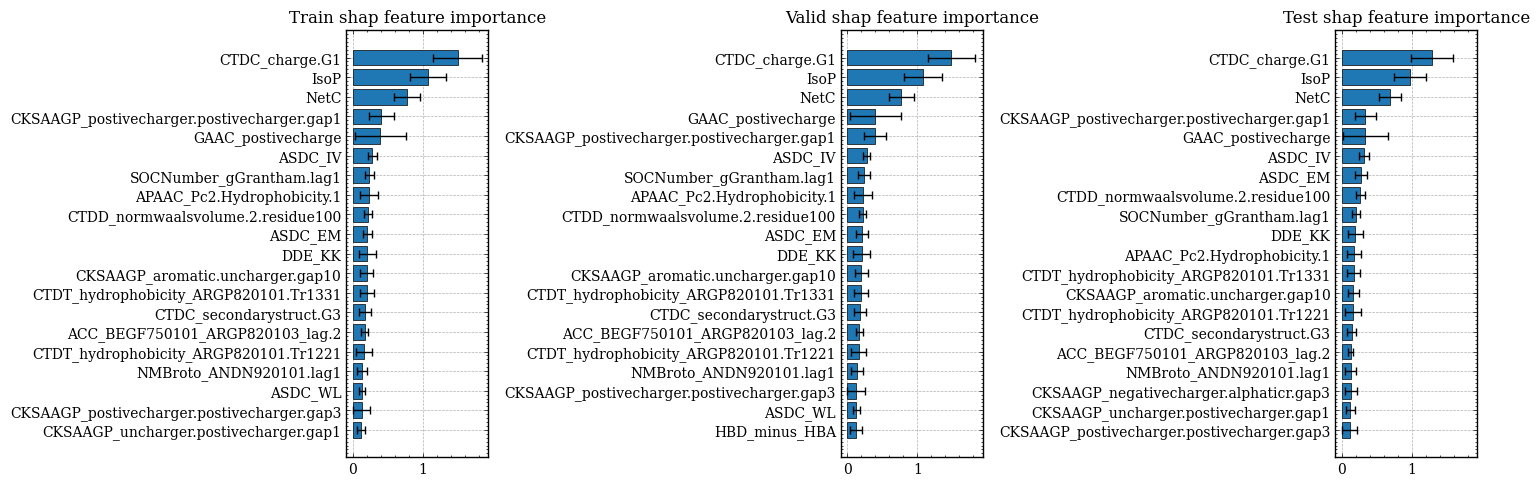

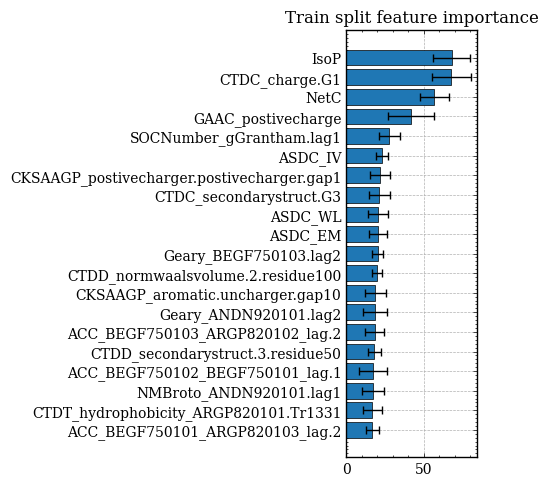

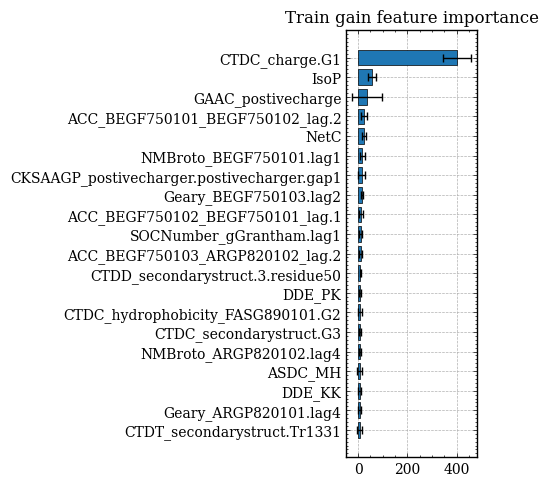

In [21]:
results = cross_validate(train=train,
                         test=test,
                         features=features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, features, max_features=20)

## Feature selection

### Part 1 - Removing irrelevant features with MDI

In [25]:
to_drop = find_irrelevant_MDI(results=results, features=features)
features = sorted(list(set(features) - set(to_drop)))
print(f'Features number: {len(features)}')

Features number: 2297


Results should match the baseline model, since only features not used by the model were removed.

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 1 + 0	cv_agg's valid auc: 0.942332 + 0.0238711
[200]	cv_agg's train auc: 1 + 0	cv_agg's valid auc: 0.945535 + 0.0222051
[100]	training's auc: 1	valid_1's auc: 0.922592
[200]	training's auc: 1	valid_1's auc: 0.922989


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Valid,0.946081,0.768790,0.876009,0.904808,0.924213,0.882235,0.832365,0.932033
Test_ensemble,0.928892,0.653800,0.672000,0.614035,0.582212,0.947458,0.797468,0.958314
Test_refit,0.922932,0.629486,0.647668,0.584112,0.549917,0.941905,0.791139,0.952817


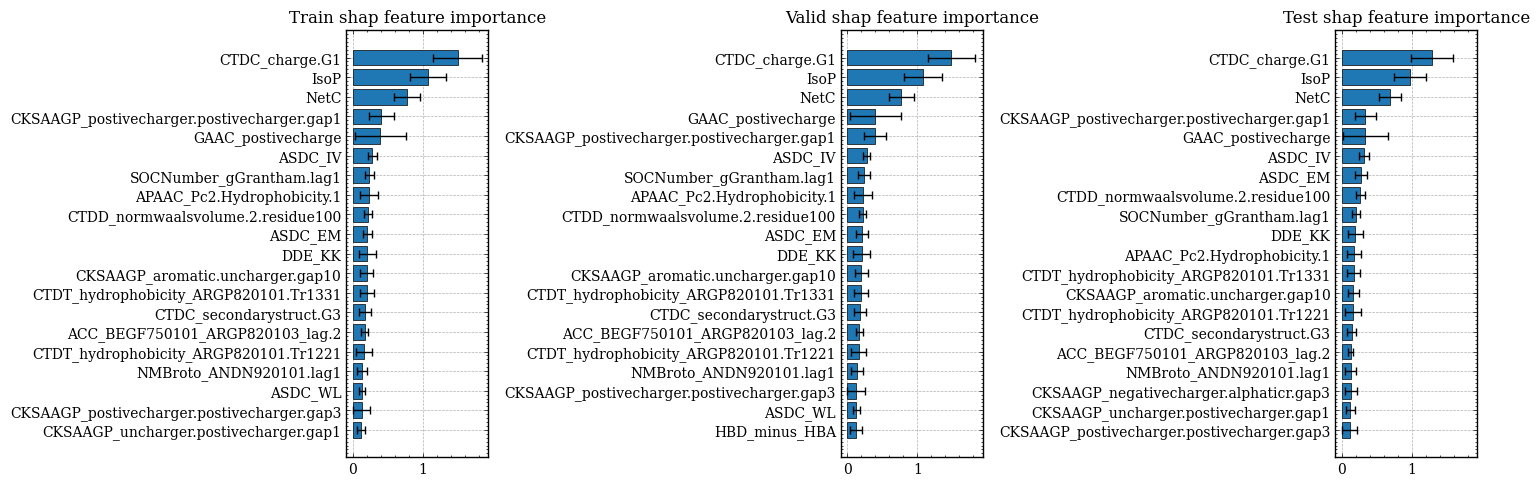

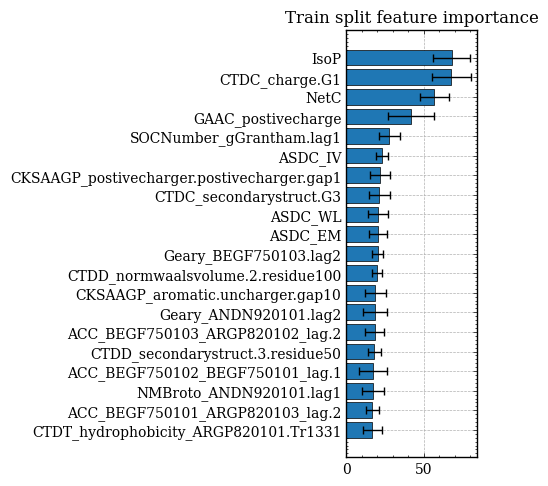

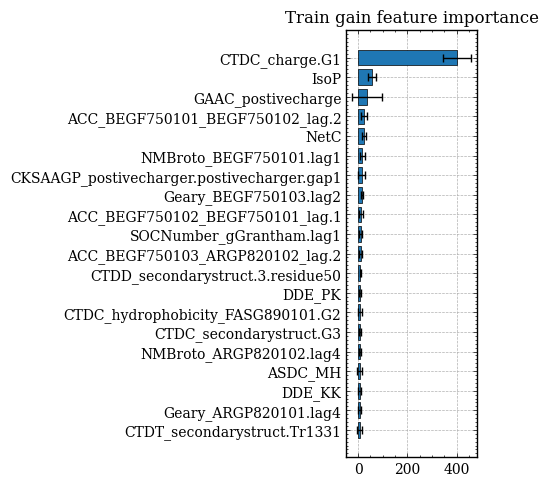

In [26]:
results = cross_validate(train=train,
                         test=test,
                         features=features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, features, max_features=20)

### Part 2 - Limiting number of leaves (to have very simple base learners and reduce inference times)

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 0.954319 + 0.00274989	cv_agg's valid auc: 0.919855 + 0.0244589
[200]	cv_agg's train auc: 0.97367 + 0.00209928	cv_agg's valid auc: 0.929603 + 0.0206185
[300]	cv_agg's train auc: 0.983383 + 0.00176984	cv_agg's valid auc: 0.933015 + 0.0191945
Early stopping, best iteration is:
[318]	cv_agg's train auc: 0.984778 + 0.00167675	cv_agg's valid auc: 0.93341 + 0.018476
[100]	training's auc: 0.953522	valid_1's auc: 0.927983
[200]	training's auc: 0.972119	valid_1's auc: 0.927973
[300]	training's auc: 0.981424	valid_1's auc: 0.929896


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,0.984778,0.767462,0.851411,0.934734,0.996555,0.870662,0.741320,1.000000
Valid,0.933410,0.649827,0.766464,0.870905,0.954379,0.806240,0.640200,0.971990
Test_ensemble,0.930299,0.687497,0.707792,0.718997,0.726283,0.961555,0.689873,0.981219
Test_refit,0.931444,0.672905,0.694534,0.701299,0.705654,0.959419,0.683544,0.979386


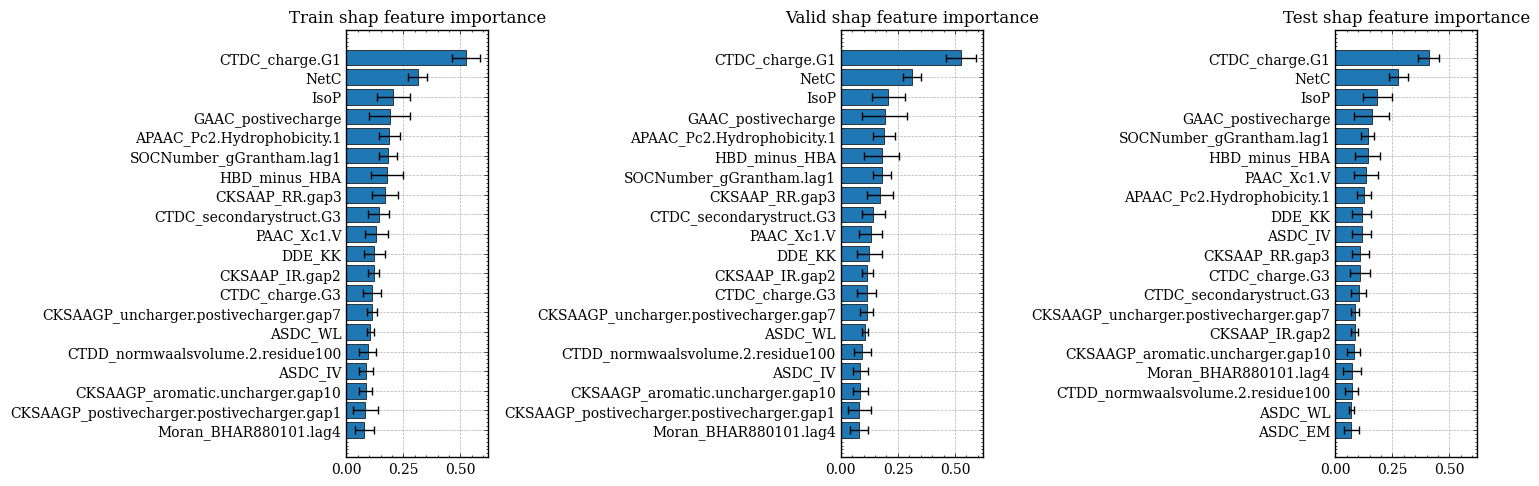

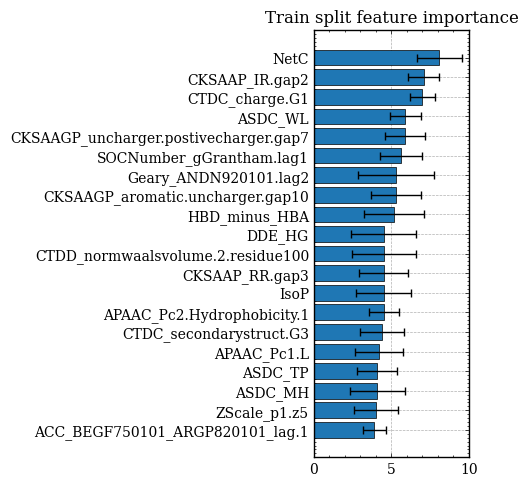

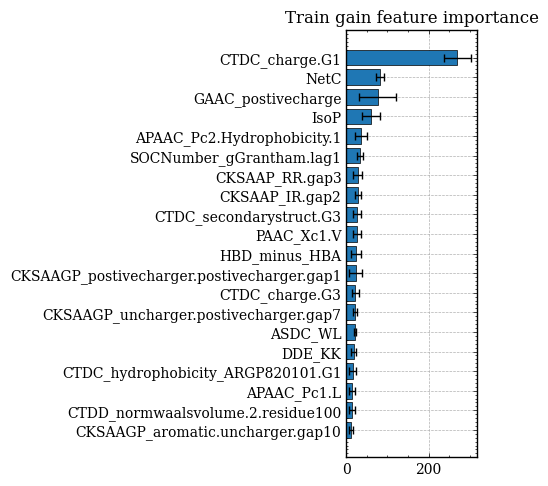

In [27]:
results = cross_validate(train=train,
                         test=test,
                         features=features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1, 'num_leaves': 2}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, features, max_features=20)

Again, we remove irrelevant features with MDI.

In [28]:
to_drop = find_irrelevant_MDI(results=results, features=features)
features = sorted(list(set(features) - set(to_drop)))
print(f'Features number: {len(features)}')

Features number: 375


And again, results should match with previous model results. This model is called in the paper **LightCPP (375 features)**.

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 0.954319 + 0.00274989	cv_agg's valid auc: 0.919855 + 0.0244589
[200]	cv_agg's train auc: 0.97367 + 0.00209928	cv_agg's valid auc: 0.929603 + 0.0206185
[300]	cv_agg's train auc: 0.983383 + 0.00176984	cv_agg's valid auc: 0.933015 + 0.0191945
Early stopping, best iteration is:
[318]	cv_agg's train auc: 0.984778 + 0.00167675	cv_agg's valid auc: 0.93341 + 0.018476
[100]	training's auc: 0.953522	valid_1's auc: 0.927983
[200]	training's auc: 0.972119	valid_1's auc: 0.927973
[300]	training's auc: 0.981257	valid_1's auc: 0.930162


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,0.984778,0.767462,0.851411,0.934734,0.996555,0.870662,0.741320,1.000000
Valid,0.933410,0.649827,0.766464,0.870905,0.954379,0.806240,0.640200,0.971990
Test_ensemble,0.930299,0.687497,0.707792,0.718997,0.726283,0.961555,0.689873,0.981219
Test_refit,0.931070,0.672905,0.694534,0.701299,0.705654,0.959419,0.683544,0.979386


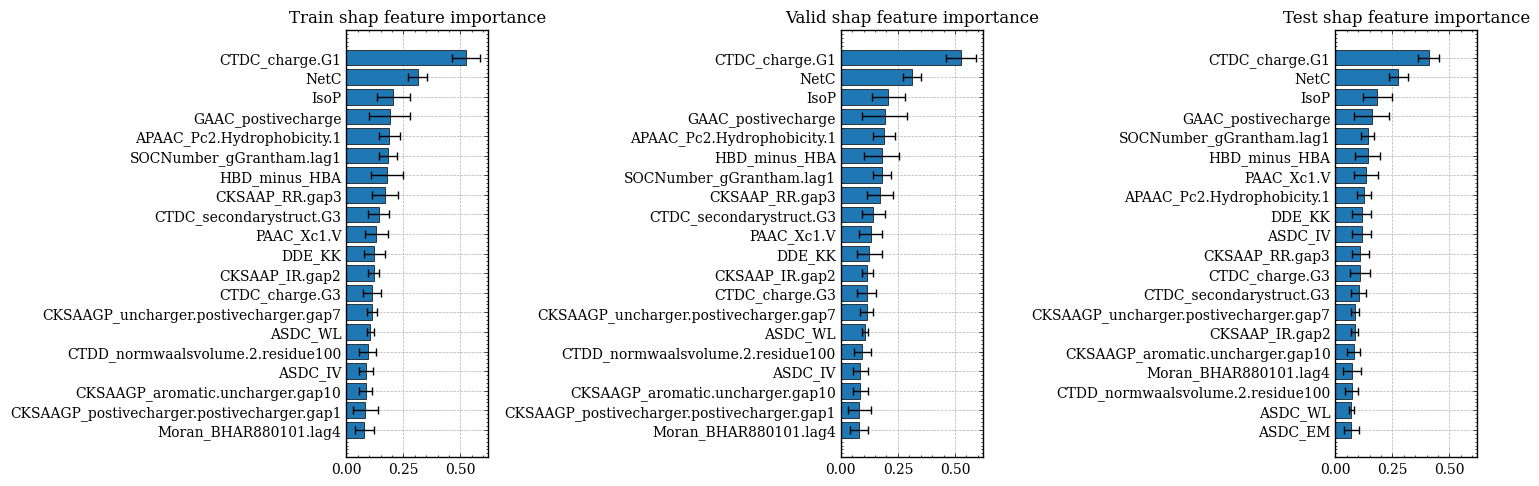

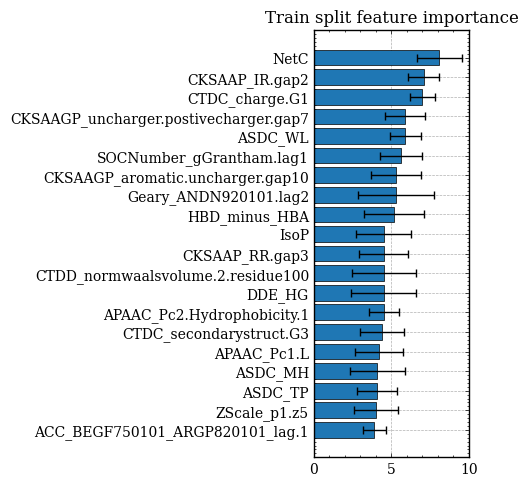

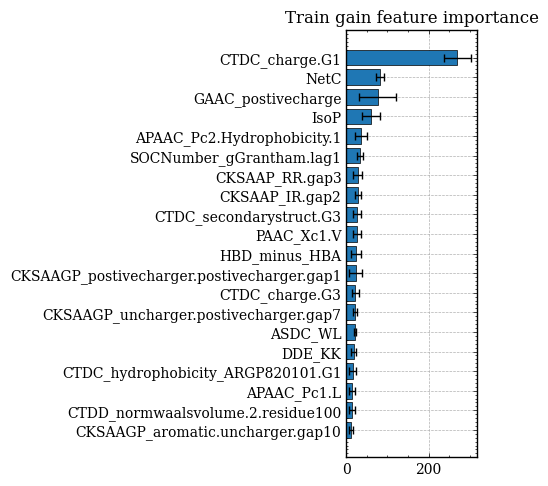

In [29]:
results = cross_validate(train=train,
                         test=test,
                         features=features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1, 'num_leaves': 2}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, features, max_features=20)

### Part 3 - Forward feature selection

In [34]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

fs_res, selected_features = forward_feature_selection_parallel(train=train,
                                                               test=test,
                                                               features=features,
                                                               target=TARGET,
                                                               num_folds=NUM_FOLDS,
                                                               num_repeats=NUM_REPEATS,
                                                               params={**PARAMS_GB, **{'num_threads':1,
                                                                                        'scale_pos_weight': 0.1,
                                                                                        'num_leaves': 2}},
                                                               seed=SEED,
                                                               threshold=0.5,
                                                               refit_multiplier=1.1,
                                                               train_score = True,
                                                               min_features_to_select=15,
                                                               max_features_to_select=20,
                                                               scoring='MCC',
                                                               n_jobs=50,
                                                               verbose=10)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  13 tasks      | elapsed:    8.6s
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    9.3s
[Parallel(n_jobs=50)]: Done  45 tasks      | elapsed:   10.4s
[Parallel(n_jobs=50)]: Done  62 tasks      | elapsed:   11.5s
[Parallel(n_jobs=50)]: Done  81 tasks      | elapsed:   12.3s
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   13.6s
[Parallel(n_jobs=50)]: Done 121 tasks      | elapsed:   15.1s
[Parallel(n_jobs=50)]: Done 142 tasks      | elapsed:   16.5s
[Parallel(n_jobs=50)]: Done 165 tasks      | elapsed:   17.8s
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:   19.0s
[Parallel(n_jobs=50)]: Done 213 tasks      | elapsed:   20.6s
[Parallel(n_jobs=50)]: Done 238 tasks      | elapsed:   22.0s
[Parallel(n_jobs=50)]: Done 265 tasks      | elapsed:   24.0s
[Parallel(n_jobs=50)]: Done 314 out of 375 | elapsed:   26.7s remaining:    5.2s
[Parallel(n_jobs=50)]: Done 352 out 

In [35]:
print(selected_features)

['CTDC_charge.G1', 'CTDD_hydrophobicity_ARGP820101.1.residue50', 'CKSAAP_IR.gap2', 'CTDD_normwaalsvolume.2.residue100', 'DDE_LA', 'ASDC_AS', 'PAAC_Xc1.V', 'APAAC_Pc2.Hydrophobicity.1', 'DDE_LP', 'CKSAAP_LL.gap4', 'APAAC_Pc1.A', 'CTDD_hydrophobicity_FASG890101.2.residue50', 'CKSAAGP_postivecharger.uncharger.gap1', 'KSCTriad_g5.g5.g5.gap1', 'ZScale_p1.z5', 'QSOrder_Grantham.Xr.T', 'ASDC_DM', 'CKSAAP_TR.gap4', 'PAAC_Xc1.G', 'CKSAAGP_uncharger.aromatic.gap9']


## Final model - LightCPP (20 features)

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 0.926267 + 0.00389047	cv_agg's valid auc: 0.909495 + 0.022844
[200]	cv_agg's train auc: 0.939826 + 0.00341086	cv_agg's valid auc: 0.91792 + 0.0246509
[300]	cv_agg's train auc: 0.948136 + 0.00372611	cv_agg's valid auc: 0.923423 + 0.0244926
[400]	cv_agg's train auc: 0.953556 + 0.00355105	cv_agg's valid auc: 0.927112 + 0.0245923
[500]	cv_agg's train auc: 0.956779 + 0.00341998	cv_agg's valid auc: 0.929405 + 0.0250501
[100]	training's auc: 0.924854	valid_1's auc: 0.910959
[200]	training's auc: 0.938117	valid_1's auc: 0.909096
[300]	training's auc: 0.947259	valid_1's auc: 0.909789
[400]	training's auc: 0.953099	valid_1's auc: 0.908642
[500]	training's auc: 0.956315	valid_1's auc: 0.908287
[600]	training's auc: 0.958599	valid_1's auc: 0.908334


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,0.957817,0.713693,0.808253,0.910752,0.990361,0.838570,0.680631,0.996509
Valid,0.930524,0.668815,0.776639,0.883498,0.968649,0.815019,0.647308,0.982547
Test_ensemble,0.908919,0.677275,0.698718,0.704134,0.707610,0.959846,0.689873,0.979386
Test_refit,0.908354,0.672905,0.694534,0.701299,0.705654,0.959419,0.683544,0.979386


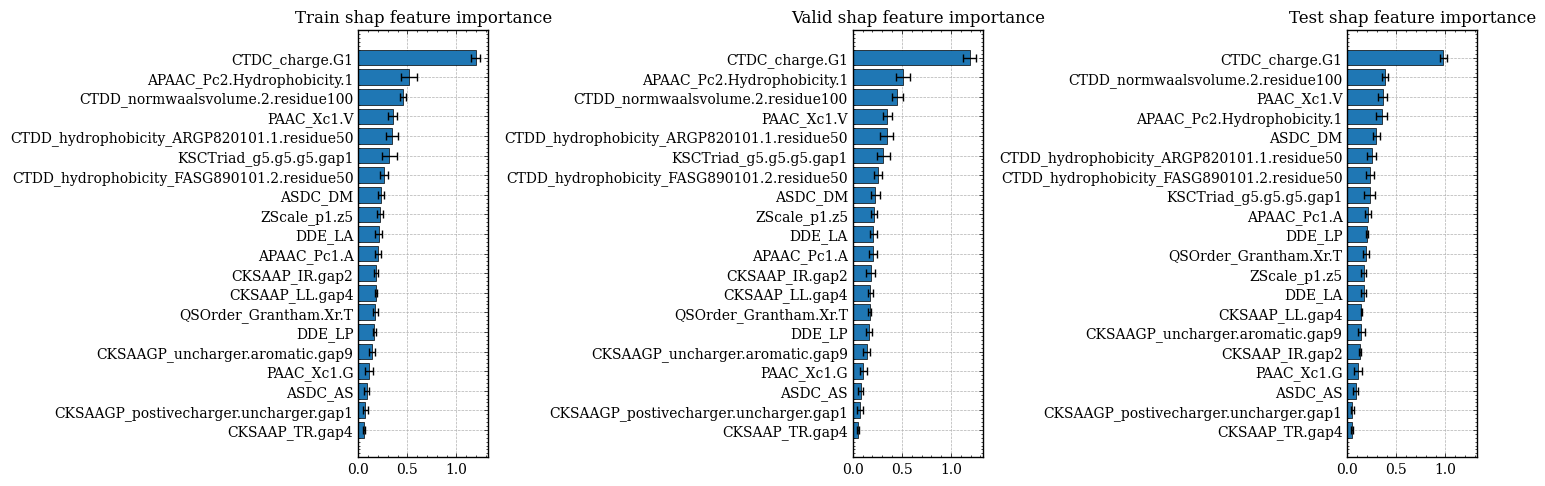

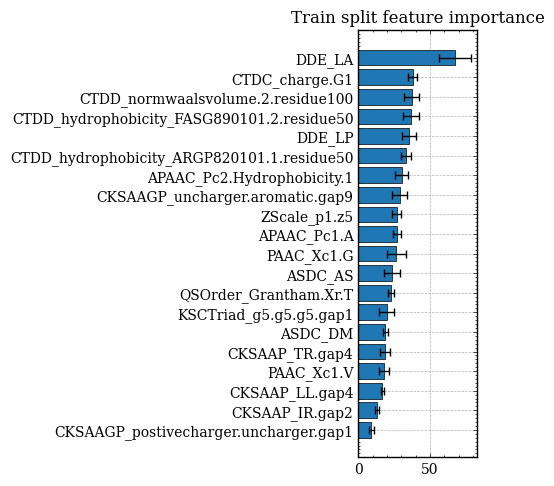

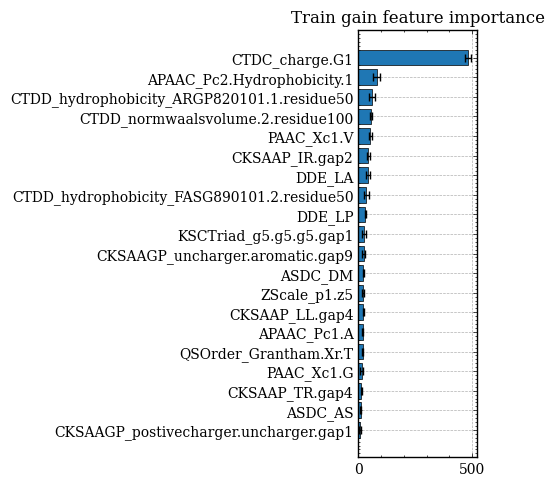

In [36]:
selected_features = ['CTDC_charge.G1',
                     'CTDD_hydrophobicity_ARGP820101.1.residue50',
                     'CKSAAP_IR.gap2',
                     'CTDD_normwaalsvolume.2.residue100',
                     'DDE_LA',
                     'ASDC_AS',
                     'PAAC_Xc1.V',
                     'APAAC_Pc2.Hydrophobicity.1',
                     'DDE_LP',
                     'CKSAAP_LL.gap4',
                     'APAAC_Pc1.A',
                     'CTDD_hydrophobicity_FASG890101.2.residue50',
                     'CKSAAGP_postivecharger.uncharger.gap1',
                     'KSCTriad_g5.g5.g5.gap1',
                     'ZScale_p1.z5',
                     'QSOrder_Grantham.Xr.T',
                     'ASDC_DM',
                     'CKSAAP_TR.gap4',
                     'PAAC_Xc1.G',
                     'CKSAAGP_uncharger.aromatic.gap9']

results = cross_validate(train=train,
                         test=test,
                         features=selected_features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1, 'num_leaves': 2}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, selected_features, max_features=20)

In [38]:
import pickle

## Save models
d = {'cv_models': results['models']['cv_models'],
     'refit_model': results['models']['refit_model'],
     'best_iteration': results['best_iteration']}

with open(os.path.join('..', 'models', 'LightCPP_20.pickle'), 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)